## Marchmadness EDA 🏀

Link to [kaggle](https://www.kaggle.com/c/march-madness-analytics-2020/data)

PHASES:
* Understand problem and data
* Preprocess features for algo input (Clean up)
* EDA
* In-depth Analysis

THINGS I WOULD DO NEXT TIME:
* Comeup with more features to engineer
* Use some of the play-by-play stats
* Incorporate each teams performance in the previous tournament game
* Weight previous tournament performance by how far they made it into the round, How well does this team perform under pressure?
* Incorporate kenpom ratings


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import torch
from IPython.display import display_html
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix,balanced_accuracy_score
from sklearn.decomposition import PCA
import statsmodels.api as sm

%matplotlib inline

## Exploring & Cleaning Data - Section 1

In [86]:
# Import Basic Data
dir_data = "google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/"
teams = pd.read_csv(dir_data + 'Mteams.csv')
season_results = pd.read_csv(dir_data + 'MRegularSeasonCompactResults.csv') 
tourney_result = pd.read_csv(dir_data + 'MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv(dir_data + 'MNCAATourneySeeds.csv')
seasons = pd.read_csv(dir_data + 'MSeasons.csv')

In [87]:
# Drop Unnessecary features
tourney_result = tourney_result.drop(['WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result

,Season,DayNum,WTeamID,LTeamID
0,1985,136,1116,1234
1,1985,136,1120,1345
2,1985,136,1207,1250
3,1985,136,1229,1425
4,1985,136,1242,1325
...,...,...,...,...
2246,2019,146,1120,1246
2247,2019,146,1277,1181
2248,2019,152,1403,1277
2249,2019,152,1438,1120


In [88]:
# Merge Seed 
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,DayNum,WTeamID,LTeamID,WSeed,LSeed
0,1985,136,1116,1234,X09,X08
1,1985,136,1120,1345,Z11,Z06
2,1985,136,1207,1250,W01,W16
3,1985,136,1229,1425,Y09,Y08
4,1985,136,1242,1325,Z03,Z14
...,...,...,...,...,...,...
2246,2019,146,1120,1246,Y05,Y02
2247,2019,146,1277,1181,W02,W01
2248,2019,152,1403,1277,X03,W02
2249,2019,152,1438,1120,Z01,Y05


In [89]:
# Engineer Clean up DayNum features
def get_round(x):
    if 134 <= int(x) <= 135:
        #'Play-in'
        return 7 
    elif 136 <= int(x) <= 137:
        return 6 #'Round 1'
    elif 138 <= int(x) <= 139:
        return 5 #'Round 2'
    elif 143 <= int(x) <= 144:
        return 4 # 'Sweet Sixteen'
    elif 145 <= int(x) <= 146:
        return 3 #'Elite Eight'
    elif int(x) == 152:
        return 2 #'Final Four'
    elif int(x) == 154:
        return 1 #'Finals'
    else: 
        return 10 #'Other'

tourney_result['Round'] = tourney_result['DayNum'].map(lambda x: get_round(x))
tourney_result = tourney_result.drop('DayNum',axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,Round
0,1985,1116,1234,X09,X08,6
1,1985,1120,1345,Z11,Z06,6
2,1985,1207,1250,W01,W16,6
3,1985,1229,1425,Y09,Y08,6
4,1985,1242,1325,Z03,Z14,6
...,...,...,...,...,...,...
2246,2019,1120,1246,Y05,Y02,3
2247,2019,1277,1181,W02,W01,3
2248,2019,1403,1277,X03,W02,2
2249,2019,1438,1120,Z01,Y05,2


In [90]:
tourney_result['WDivision'] = tourney_result['WSeed'].map(lambda x: x[0])
tourney_result['LDivision'] = tourney_result['LSeed'].map(lambda x: x[0])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: int(x[1:3]))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: int(x[1:3]))

tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,Round,WDivision,LDivision
0,1985,1116,1234,9,8,6,X,X
1,1985,1120,1345,11,6,6,Z,Z
2,1985,1207,1250,1,16,6,W,W
3,1985,1229,1425,9,8,6,Y,Y
4,1985,1242,1325,3,14,6,Z,Z
...,...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,3,Y,Y
2247,2019,1277,1181,2,1,3,W,W
2248,2019,1403,1277,3,2,2,X,W
2249,2019,1438,1120,1,5,2,Z,Y


In [91]:
# Merge total regular season points
season_result = pd.read_csv(dir_data + 'MRegularSeasonCompactResults.csv')
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_result

,Season,TeamID,Score
0,1985,1228,81
1,1985,1106,77
2,1985,1112,63
3,1985,1165,70
4,1985,1192,86
...,...,...,...
323099,2019,1222,57
323100,2019,1426,64
323101,2019,1276,60
323102,2019,1382,53


In [92]:
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_score

,Season,TeamID,Score
0,1985,1102,1514
1,1985,1103,1404
2,1985,1104,2055
3,1985,1106,1719
4,1985,1108,2075
...,...,...,...
11236,2019,1462,2372
11237,2019,1463,2265
11238,2019,1464,2205
11239,2019,1465,1962


In [93]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,Round,WDivision,LDivision,WScoreT,LScoreT
0,1985,1116,1234,9,8,6,X,X,2156,2092
1,1985,1120,1345,11,6,6,Z,Z,2040,1728
2,1985,1207,1250,1,16,6,W,W,2045,1907
3,1985,1229,1425,9,8,6,Y,Y,1933,1915
4,1985,1242,1325,3,14,6,Z,Z,2281,1824
...,...,...,...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,3,Y,Y,2682,2532
2247,2019,1277,1181,2,1,3,W,W,2680,2839
2248,2019,1403,1277,3,2,2,X,W,2339,2680
2249,2019,1438,1120,1,5,2,Z,Y,2299,2682


In [94]:
tourney_win_result = tourney_result.copy()
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)
tourney_win_result

,Season,WTeamID,LTeamID,Seed1,Seed2,Round,WDivision,LDivision,ScoreT1,ScoreT2
0,1985,1116,1234,9,8,6,X,X,2156,2092
1,1985,1120,1345,11,6,6,Z,Z,2040,1728
2,1985,1207,1250,1,16,6,W,W,2045,1907
3,1985,1229,1425,9,8,6,Y,Y,1933,1915
4,1985,1242,1325,3,14,6,Z,Z,2281,1824
...,...,...,...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,3,Y,Y,2682,2532
2247,2019,1277,1181,2,1,3,W,W,2680,2839
2248,2019,1403,1277,3,2,2,X,W,2339,2680
2249,2019,1438,1120,1,5,2,Z,Y,2299,2682


In [95]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2'].astype(int)
tourney_lose_result['Seed2'] = tourney_win_result['Seed1'].astype(int)
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2'].astype(int)
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1'].astype(int)
tourney_lose_result

,Season,WTeamID,LTeamID,Seed1,Seed2,Round,WDivision,LDivision,ScoreT1,ScoreT2
0,1985,1116,1234,8,9,6,X,X,2092,2156
1,1985,1120,1345,6,11,6,Z,Z,1728,2040
2,1985,1207,1250,16,1,6,W,W,1907,2045
3,1985,1229,1425,8,9,6,Y,Y,1915,1933
4,1985,1242,1325,14,3,6,Z,Z,1824,2281
...,...,...,...,...,...,...,...,...,...,...
2246,2019,1120,1246,2,5,3,Y,Y,2532,2682
2247,2019,1277,1181,1,2,3,W,W,2839,2680
2248,2019,1403,1277,2,3,2,X,W,2680,2339
2249,2019,1438,1120,5,1,2,Z,Y,2682,2299


In [96]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [97]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

,Season,WTeamID,LTeamID,Seed1,Seed2,Round,WDivision,LDivision,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,1985,1116,1234,9,8,6,X,X,2156,2092,1,64,1
1,1985,1120,1345,11,6,6,Z,Z,2040,1728,5,312,1
2,1985,1207,1250,1,16,6,W,W,2045,1907,-15,138,1
3,1985,1229,1425,9,8,6,Y,Y,1933,1915,1,18,1
4,1985,1242,1325,3,14,6,Z,Z,2281,1824,-11,457,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,2019,1120,1246,2,5,3,Y,Y,2532,2682,-3,-150,0
4498,2019,1277,1181,1,2,3,W,W,2839,2680,-1,159,0
4499,2019,1403,1277,2,3,2,X,W,2680,2339,-1,341,0
4500,2019,1438,1120,5,1,2,Z,Y,2682,2299,4,383,0


# Baseline Model
* Logistic Regression on basic season data (Seed difference & total season scoring)
* Look at which features have the highest correlation with winning

In [101]:
#Train First Model; logistic regression on:
tourney_result_clean = tourney_result.drop(['Season', 'WTeamID', 'LTeamID','LDivision','WDivision'], axis=1)[tourney_result['Season'] >= 2003]
X_train = tourney_result_clean.drop('result', axis=1)
y_train = tourney_result_clean.result
X_train, y_train = shuffle(X_train, y_train)

In [102]:
logreg = LogisticRegression(solver='liblinear')
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5571, with best C: 0.001


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax

S = model_pipeline.fit(X_train, y_train)
y_pred = S.predict(X_train)
plot_confusion_matrix(y_train, y_pred,S.classes_)

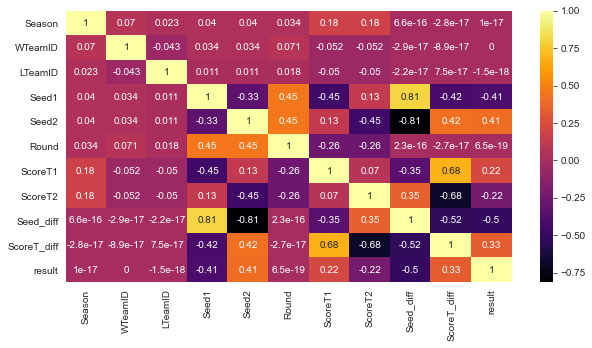

In [104]:
# Features Correlated with Wins
f,ax = plt.subplots(figsize=(10,5))
corr = tourney_result.corr()
sns.heatmap(corr, cmap='inferno', annot=True)

## Data Section 2 - Team Box Scores & Advanced Stats
Add Aggregate values of the detailed stats + feature engineer advanced stats .
All advanced stats derived from this notebook https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stat

In [105]:
#LOAD DATA
df_det = pd.read_csv(dir_data +'MRegularSeasonDetailedResults.csv')
df = df_det.copy()

In [106]:
#Points Winning/Losing Team
df['WPts'] = df.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
df['LPts'] = df.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

#Calculate Winning/losing Team Possesion Feature
wPos = df.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = df.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)

#Calculate possesion percentages, redundant but will help by later
df['Pos'] = (wPos+lPos) / 2

In [107]:
#Offensive efficiency (OffRtg) = 100 x (Points / Possessions)
df['WOffRtg'] = df.apply(lambda row: 100 * (row.WPts / row.Pos), axis=1)
df['LOffRtg'] = df.apply(lambda row: 100 * (row.LPts / row.Pos), axis=1)
#Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions)
df['WDefRtg'] = df.LOffRtg
df['LDefRtg'] = df.WOffRtg
#Net Rating = Off.Rtg - Def.Rtg
df['WNetRtg'] = df.apply(lambda row:(row.WOffRtg - row.WDefRtg), axis=1)
df['LNetRtg'] = df.apply(lambda row:(row.LOffRtg - row.LDefRtg), axis=1)
                         
#Assist Ratio : Percentage of team possessions that end in assists
df['WAstR'] = df.apply(lambda row: 100 * row.WAst / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df['LAstR'] = df.apply(lambda row: 100 * row.LAst / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
#Turnover Ratio: Number of turnovers of a team per 100 possessions used.
#(TO * 100) / (FGA + (FTA * 0.44) + AST + TO)
df['WTOR'] = df.apply(lambda row: 100 * row.WTO / (row.WFGA + 0.44*row.WFTA + row.WAst + row.WTO), axis=1)
df['LTOR'] = df.apply(lambda row: 100 * row.LTO / (row.LFGA + 0.44*row.LFTA + row.LAst + row.LTO), axis=1)
                    
#The Shooting Percentage : Measure of Shooting Efficiency (FGA/FGA3, FTA)
df['WTSP'] = df.apply(lambda row: 100 * row.WPts / (2 * (row.WFGA + 0.44 * row.WFTA)), axis=1)
df['LTSP'] = df.apply(lambda row: 100 * row.LPts / (2 * (row.LFGA + 0.44 * row.LFTA)), axis=1)
#eFG% : Effective Field Goal Percentage adjusting for the fact that 3pt shots are more valuable 
df['WeFGP'] = df.apply(lambda row:(row.WFGM + 0.5 * row.WFGM3) / row.WFGA, axis=1)      
df['LeFGP'] = df.apply(lambda row:(row.LFGM + 0.5 * row.LFGM3) / row.LFGA, axis=1)   
#FTA Rate : How good a team is at drawing fouls.
df['WFTAR'] = df.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df['LFTAR'] = df.apply(lambda row: row.LFTA / row.LFGA, axis=1)
                         
#OREB% : Percentage of team offensive rebounds
df['WORP'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['LORP'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
#DREB% : Percentage of team defensive rebounds
df['WDRP'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['LDRP'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)                                      
#REB% : Percentage of team total rebounds
df['WRP'] = df.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
df['LRP'] = df.apply(lambda row: (row.LDR + row.LOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)



In [108]:
# Engineer percentages
# 3 pointer percentages
df['WFGM3%'] = df['WFGM3'] / (df['WFGA3'])
df['LFGM3%'] = df['LFGM3'] / (df['LFGA3'])

# Field goals percentages
df['WFGM%'] = df['WFGM'] / ( df['WFGA'])
df['LFGM%'] = df['LFGM'] / ( df['LFGA'])

# Free throw percentages
df['WFTM%'] = df['WFTM'] / ( df['WFTA'])
df['LFTM%'] = df['LFTM'] / ( df['LFTA'])

In [109]:

# Get Split data into winning team's Stats and losting Team's stats
w_cols = ['Season', 'WTeamID',
                    'WFGM','WFGM%', 'WFGA', 'WFGM3','WFGM3%', 'WFGA3', 'WFTM','WFTM%','WFTA', 'WOR', 'WDR',
                    'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'Pos', 'WOffRtg', 'WDefRtg',
                    'WNetRtg','WAstR', 'WTOR','WTSP', 
                    'WeFGP', 'WFTAR', 'WORP', 'WDRP',
                    'WRP']
l_cols = []
for i in w_cols: l_cols.append(i.replace('W','L'))
season_win_stats = df[w_cols]
season_lose_stats = df[l_cols]

In [110]:
#Create dictionary for columns to be renamed by
standard_names = []
for i in w_cols: 
    if i == 'Season' or i == 'Pos':
        standard_names.append(i)
    else:
        standard_names.append(i[1:])

w_col_dict =  dict(zip(w_cols, standard_names))
l_col_dict =  dict(zip(l_cols, standard_names))


season_win_stats.rename(columns=w_col_dict, inplace=True)
season_lose_stats.rename(columns=l_col_dict, inplace=True)

season_stats = pd.concat((season_win_stats, season_lose_stats)).reset_index(drop=True)

season_stats = season_stats.groupby(['Season', 'TeamID']).mean().reset_index()
season_stats.sort_values(by=['TeamID','Season'], inplace=True)
season_stats = season_stats.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [111]:
# Save this for later EDA
season_stats.to_csv('season_advanced_stats_2003+.csv')

In [112]:
# Merge these season stats to the tournament outcomes
inverted_w_col_dict = {v: k for k, v in w_col_dict.items()}
inverted_l_col_dict = {v: k for k, v in l_col_dict.items()}
inverted_w_col_dict.pop('TeamID', None)
inverted_l_col_dict.pop('TeamID', None)
inverted_w_col_dict['Pos'] = 'WPos'
inverted_l_col_dict['Pos'] = 'LPos'

tourney_result = pd.merge(tourney_result, season_stats, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns=inverted_w_col_dict, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)

tourney_result = pd.merge(tourney_result, season_stats, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns=inverted_l_col_dict, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,Seed1,Seed2,Round,WDivision,LDivision,ScoreT1,ScoreT2,...,LDefRtg,LNetRtg,LAstR,LTOR,LTSP,LeFGP,LFTAR,LORP,LDRP,LRP
0,1985,1116,1234,9,8,6,X,X,2156,2092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,1120,1345,11,6,6,Z,Z,2040,1728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,1207,1250,1,16,6,W,W,2045,1907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,1229,1425,9,8,6,Y,Y,1933,1915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,1242,1325,3,14,6,Z,Z,2281,1824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,2019,1120,1246,2,5,3,Y,Y,2532,2682,...,100.697531,17.979024,14.904024,13.664529,58.278103,0.533996,0.435327,0.365249,0.742956,0.565908
4498,2019,1277,1181,1,2,3,W,W,2839,2680,...,96.387059,22.492368,15.263206,12.873723,56.915042,0.536352,0.354922,0.363439,0.706024,0.539600
4499,2019,1403,1277,2,3,2,X,W,2680,2339,...,99.928569,20.231412,19.066958,13.278198,59.813862,0.558036,0.356940,0.340396,0.736020,0.562396
4500,2019,1438,1120,5,1,2,Z,Y,2682,2299,...,104.321009,15.192208,14.903352,12.762008,57.625028,0.542735,0.320622,0.319014,0.674780,0.488777


In [113]:
tourney_result_2003 = tourney_result[tourney_result['Season'] >= 2003]

In [114]:
# Differences
w_list = list(inverted_w_col_dict.values())
l_list = list(inverted_l_col_dict.values())
for i in range(1,len(w_cols)-1):
    tourney_result_2003[l_list[i][1:] + '_diff'] = tourney_result_2003[w_list[i]] - tourney_result_2003[l_list[i]]
    tourney_result_2003.drop([w_list[i]], axis=1,inplace=True)
    tourney_result_2003.drop([l_list[i]], axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [133]:
tourney_result_2003.columns

Index(['Season', 'WTeamID', 'LTeamID', 'Seed1', 'Seed2', 'Round', 'WDivision',
       'LDivision', 'ScoreT1', 'ScoreT2', 'Seed_diff', 'ScoreT_diff', 'result',
       'FGM_diff', 'FGM%_diff', 'FGA_diff', 'FGM3_diff', 'FGM3%_diff',
       'FGA3_diff', 'FTM_diff', 'FTM%_diff', 'FTA_diff', 'OR_diff', 'DR_diff',
       'Ast_diff', 'TO_diff', 'Stl_diff', 'Blk_diff', 'PF_diff', 'Pos_diff',
       'OffRtg_diff', 'DefRtg_diff', 'NetRtg_diff', 'AstR_diff', 'TOR_diff',
       'TSP_diff', 'eFGP_diff', 'FTAR_diff', 'ORP_diff', 'DRP_diff', 'RP_diff',
       'LQuality', 'WQuality', 'Wpowerrank', 'Lpowerrank'],
      dtype='object')

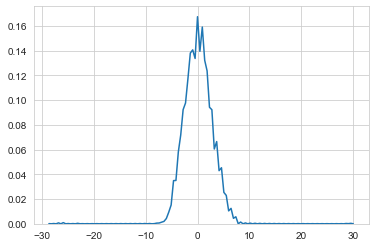

In [116]:
# Team Power Rankings - Taken directly from https://www.kaggle.com/raddar/team-power-rankings
#tourney_result_2003
#df_det
seeds = pd.read_csv(dir_data + 'MNCAATourneySeeds.csv')
tourney_results2 = pd.read_csv(dir_data + 'MNCAATourneyCompactResults.csv')
regular_results = pd.read_csv(dir_data + 'MRegularSeasonCompactResults.csv') 

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'         
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).sort_index().reset_index(drop=True)
    
    return output
tourney_results2 = prepare_data(tourney_results2)
regular_results = prepare_data(regular_results)


# convert to str, so the model would treat TeamID them as factors
regular_results['T1_TeamID'] = regular_results['T1_TeamID'].astype(str)
regular_results['T2_TeamID'] = regular_results['T2_TeamID'].astype(str)

# make it a binary task
regular_results['win'] = np.where(regular_results['T1_Score']>regular_results['T2_Score'], 1, 0)

def team_quality(season):
    """
    Calculate team quality for each season seperately. 
    Team strength changes from season to season (students playing change!)
    So pooling everything would be bad approach!
    """
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_results.loc[regular_results.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    # extracting parameters from glm
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','beta']
    quality['Season'] = season
    # taking exp due to binomial model being used
    quality['quality'] = np.exp(quality['beta'])
    # only interested in glm parameters with T1_, as T2_ should be mirroring T1_ ones
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

team_quality = pd.concat([team_quality(2003),
                          team_quality(2004),
                          team_quality(2005),
                          team_quality(2006),
                          team_quality(2007),
                          team_quality(2008),
                          team_quality(2009),
                          team_quality(2010),
                          team_quality(2011),
                          team_quality(2012),
                          team_quality(2013),
                          team_quality(2014),
                          team_quality(2015),
                          team_quality(2016),
                          team_quality(2017),
                          team_quality(2018),
                          team_quality(2019)]).reset_index(drop=True)

sns.set_style('whitegrid')
sns.kdeplot(np.array(team_quality['beta']), bw=0.1)

In [117]:
team_quality_W = team_quality[['TeamID','Season','quality']].copy()
team_quality_W.columns = ['WTeamID','Season','WQuality']

team_quality_L = team_quality[['TeamID','Season','quality']].copy()
team_quality_L.columns = ['LTeamID','Season','LQuality']


tourney_result_2003 = pd.merge(tourney_result_2003, team_quality_L, left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'], how='left')
tourney_result_2003 = pd.merge(tourney_result_2003, team_quality_W, left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'], how='left')



In [119]:
tourney_result_2003['Wpowerrank'] = tourney_result_2003.groupby(['Season','WDivision'])['WQuality'].rank(method='dense', ascending=False).astype(int)
tourney_result_2003['Lpowerrank'] = tourney_result_2003.groupby(['Season','LDivision'])['LQuality'].rank(method='dense', ascending=False).astype(int)
tourney_result_2003

,Season,WTeamID,LTeamID,Seed1,Seed2,Round,WDivision,LDivision,ScoreT1,ScoreT2,...,TSP_diff,eFGP_diff,FTAR_diff,ORP_diff,DRP_diff,RP_diff,LQuality,WQuality,Wpowerrank,Lpowerrank
0,2003,1421,1411,16,16,7,X,X,2065,2184,...,0.200577,-0.013235,-0.152277,-0.012949,-0.056104,-0.030010,0.158817,0.300536,9,17
1,2003,1112,1436,1,16,6,Z,Z,2386,1966,...,2.895113,0.022900,0.031691,0.014010,-0.052338,-0.013179,0.650237,42.710561,1,16
2,2003,1113,1272,10,7,6,Z,Z,2203,2161,...,2.285861,0.018997,0.071937,0.031277,0.000045,0.010731,12.577559,7.704377,6,7
3,2003,1141,1166,11,6,6,Z,Z,2301,2615,...,2.713634,0.005381,0.127689,0.019944,-0.019458,0.007251,13.600178,4.880807,8,5
4,2003,1143,1301,8,9,6,W,W,2160,2172,...,-2.565404,-0.010092,-0.039185,0.013497,0.010425,0.009767,6.628850,10.200473,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,2019,1120,1246,2,5,3,Y,Y,2532,2682,...,-0.653074,0.008738,-0.114706,-0.046235,-0.068176,-0.077131,69.240605,28.628348,5,2
2226,2019,1277,1181,1,2,3,W,W,2839,2680,...,2.898820,0.021684,0.002018,-0.023043,0.029996,0.022796,123.422426,60.085118,2,1
2227,2019,1403,1277,2,3,2,X,W,2680,2339,...,-2.194891,-0.020284,-0.013845,-0.054718,-0.015814,-0.046075,60.085118,39.415018,4,2
2228,2019,1438,1120,5,1,2,Z,Y,2682,2299,...,1.592793,0.014524,-0.009975,-0.022933,0.062590,0.048303,28.628348,153.259286,1,5


## Test new baseline with more features

In [160]:
tourney_result_clean = tourney_result_2003.drop(['Season', 'WTeamID', 'LTeamID','LDivision','WDivision'], axis=1)

X_train = tourney_result_clean.drop('result', axis=1)
y_train = tourney_result_clean.result
X_train, y_train = shuffle(X_train, y_train)

In [161]:
model_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(0.90, svd_solver='full')),
    ('logreg', LogisticRegression(solver='liblinear'))
])
params = {'logreg__C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(model_pipeline, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(-clf.best_score_, clf.best_params_['logreg__C']))

Best log_loss: 0.5631, with best C: 0.1


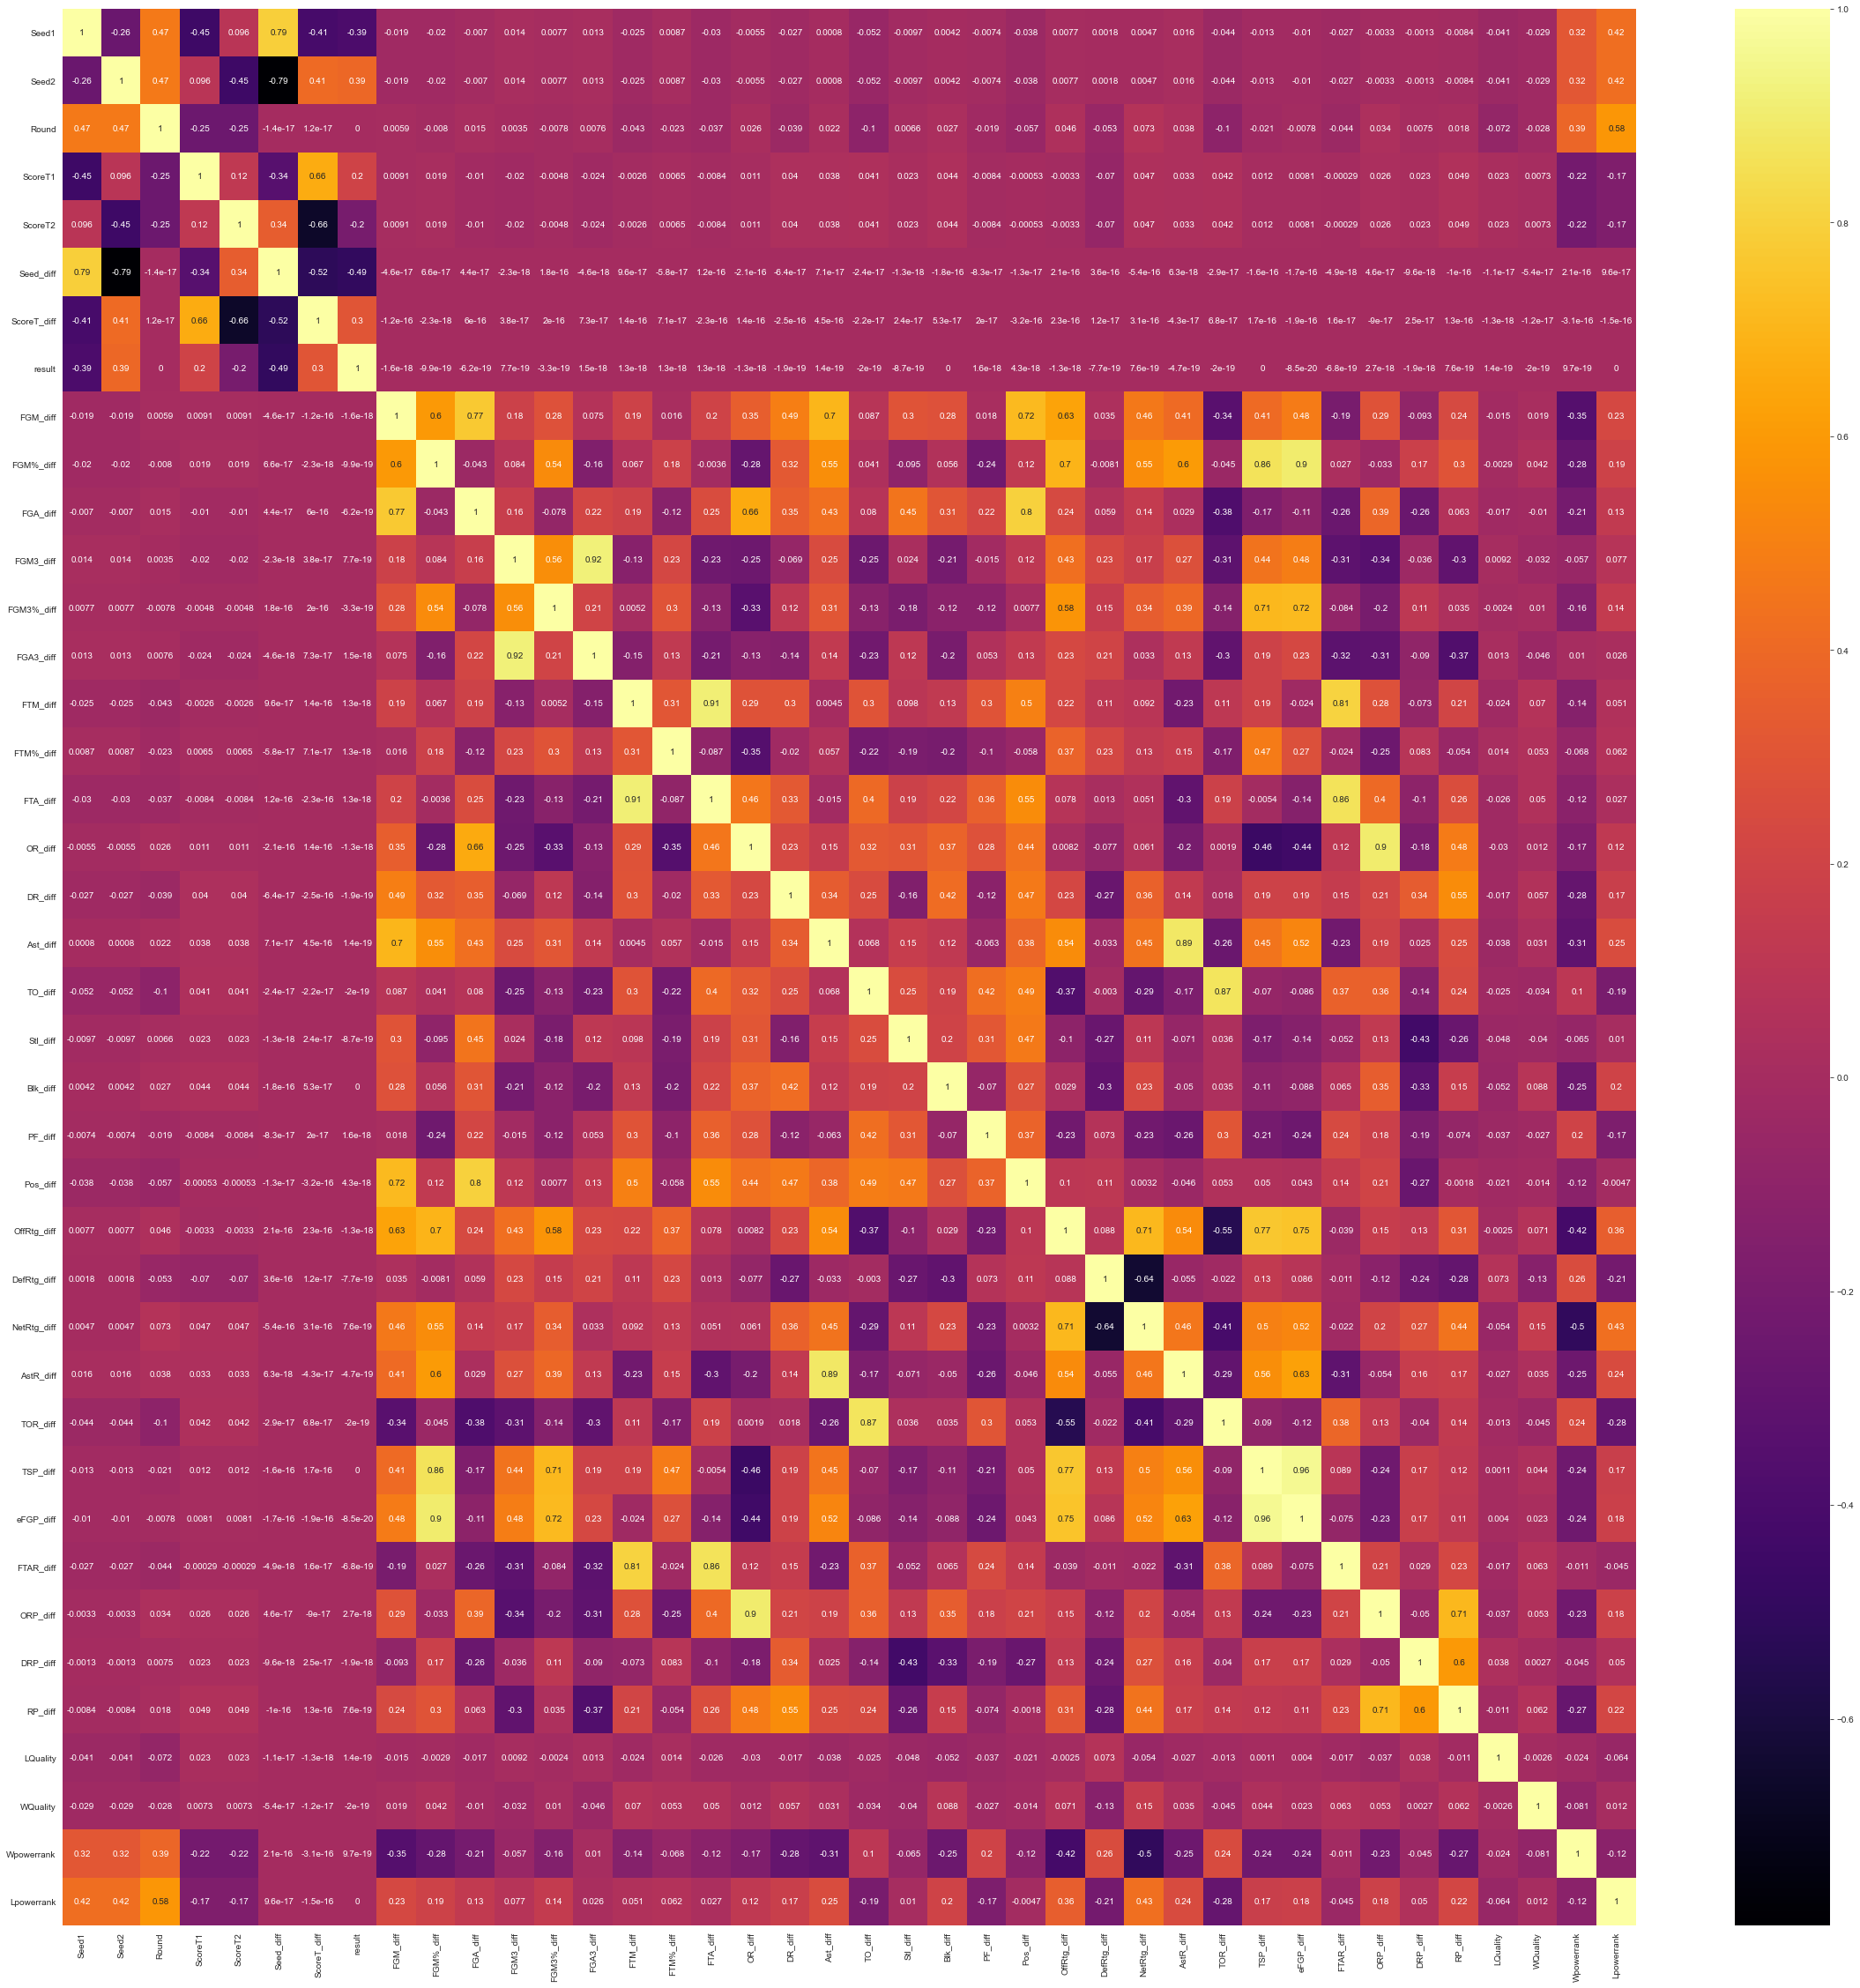

In [162]:
# Features Correlated with Wins
f,ax = plt.subplots(figsize=(40,40))
corr = tourney_result_clean.corr()
sns.heatmap(corr, cmap='inferno', annot=True)

In [164]:
# Now we have a dataset that we can work on, lets save this and move to a new notebook
tourney_result_2003.to_csv('tourney_result_2003+.csv')